# Test the efficiency of DIVOT

In [1]:
from util import *
from jax import grad, value_and_grad, jit,vmap, random


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/config.py:163: UserWarning: enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;
see https://github.com/google/jax/blob/master/design_notes/omnistaging.md
  "enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;\n"


In [2]:
@jit
def loss_jax(params, df_batch,un):
    x,y = df_batch[:,0],df_batch[:,1]
    vec = jnp.sort(y) - jnp.sort(params*un)
    return jnp.var(vec)

val_and_grad = value_and_grad(loss_jax)
vmap_val_and_grad_inner = vmap(val_and_grad, in_axes=(None,None,1),out_axes=0)  
vmap_val_and_grad_outer = vmap(vmap_val_and_grad_inner, in_axes=(None,0,2),out_axes=0)  
vmap_val_and_grad_outer = jit(vmap_val_and_grad_outer)

In [3]:
def batch_test(df,resolution,npos):
    nghM = get_neighbor_matrix_fixed_num(df, resolution)
    batches = get_batches(data=df, neighborM=nghM, resolution=resolution, npos=npos)
    batches = jnp.array(batches)

    df_batch = batches[0]
    batch_sz,_ = df_batch.shape
    return batches,batch_sz

In [4]:
def test(batches,key_seed=42,step_sz = 1.0,exp = 200,nrep = 100):
    key = random.PRNGKey(key_seed)
    df_batch = batches[0]
    batch_sz,_ = df_batch.shape
    theta_H =0.2
    params = theta_H

    loss_res = []
    t_res = []
    gradt_res = []

    for j in range(exp):
        key, subkey = random.split(key)
        un = random.uniform(subkey,shape=(batch_sz,nrep,len(batches)),minval=0.0, maxval=1.0)
        loss_val,grad = vmap_val_and_grad_outer(params, batches, un)
        ave_loss,ave_grad = np.mean(loss_val),np.mean(grad)
        params -= step_sz * ave_grad
        loss_res.append(ave_loss)
        t_res.append(params)
        gradt_res.append(ave_grad)
    return loss_res,t_res,gradt_res,params

# Data generation and test the running time of DIVOT
Generate a dataset with sample size 10000

## Number of positions: 50 or 100, batch size: 0.001

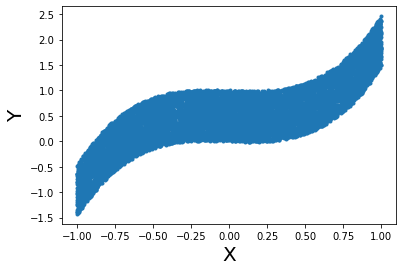

In [5]:
nsamples = 10000
resolution = 0.001
npos = 50  #100

def f_t(x):
    return 0.1*((2.5*x)**3 - x)

# Generate random ground truth W and b
key = random.PRNGKey(0)
k1, k2 = random.split(key)

# Generate samples with additional noise
ksample, knoise = random.split(k1)
x_samples = random.uniform(k1,shape=(nsamples, 1),minval=-1, maxval=1)

# y_samples = vmap(f_t)(x_samples)
y_samples = np.array([f_t(x) for x in x_samples])
y_samples += 1.0*random.uniform(knoise,shape=(nsamples, 1),minval=0.0, maxval=1.0)
x= x_samples.reshape(-1)
y= y_samples.reshape(-1)
plt.scatter(x,y,marker='.')
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
# plt.title('$Y =  X + E_y$ ')
n = nsamples
df_c = np.zeros([n,2])
df_c[:,0],df_c[:,1] = x,y
df_sort_c = sortBycol(df_c,0)

df_rv = np.zeros([n,2])
df_rv[:,0],df_rv[:,1] = y,x
df_sort_rv = sortBycol(df_rv,0)

In [6]:
c_batches,c_batch_sz = batch_test(df_sort_c,resolution,npos)
%timeit c_loss_res, c_t_res, c_gradt_res, params_c = test(c_batches, key_seed = 42, step_sz = 1.0, exp = 100,nrep = 50)

241 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Number of positions: 50 or 100, batch size: 0.01

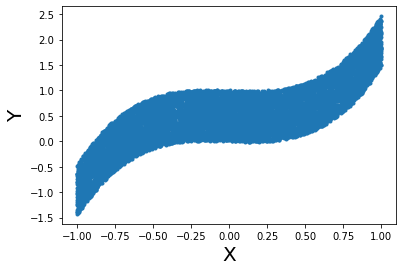

In [7]:
nsamples = 10000
resolution = 0.01
npos = 50  # 100

def f_t(x):
    return 0.1*((2.5*x)**3 - x)

# Generate random ground truth W and b
key = random.PRNGKey(0)
k1, k2 = random.split(key)

# Generate samples with additional noise
ksample, knoise = random.split(k1)
x_samples = random.uniform(k1,shape=(nsamples, 1),minval=-1, maxval=1)

y_samples = np.array([f_t(x) for x in x_samples])
y_samples += 1.0*random.uniform(knoise,shape=(nsamples, 1),minval=0.0, maxval=1.0)
x= x_samples.reshape(-1)
y= y_samples.reshape(-1)
plt.scatter(x,y,marker='.')
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
# plt.title('$Y =  X + E_y$ ')
n = nsamples
df_c = np.zeros([n,2])
df_c[:,0],df_c[:,1] = x,y
df_sort_c = sortBycol(df_c,0)

df_rv = np.zeros([n,2])
df_rv[:,0],df_rv[:,1] = y,x
df_sort_rv = sortBycol(df_rv,0)

In [8]:
c_batches,c_batch_sz = batch_test(df_sort_c,resolution,npos)
%timeit c_loss_res, c_t_res, c_gradt_res, params_c = test(c_batches, key_seed = 42, step_sz = 1.0, exp = 100,nrep = 50)

7.22 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Number of positions: 50 or 100, batch size: 0.1

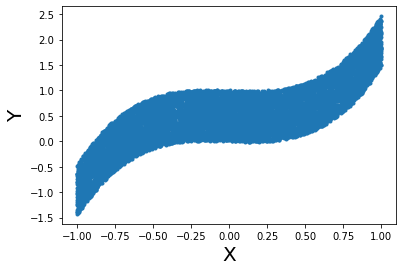

In [9]:
nsamples = 10000
resolution = 0.1
npos = 50  # 100

def f_t(x):
    return 0.1*((2.5*x)**3 - x)

# Generate random ground truth W and b
key = random.PRNGKey(0)
k1, k2 = random.split(key)

# Generate samples with additional noise
ksample, knoise = random.split(k1)
x_samples = random.uniform(k1,shape=(nsamples, 1),minval=-1, maxval=1)

y_samples = np.array([f_t(x) for x in x_samples])
y_samples += 1.0*random.uniform(knoise,shape=(nsamples, 1),minval=0.0, maxval=1.0)
x= x_samples.reshape(-1)
y= y_samples.reshape(-1)
plt.scatter(x,y,marker='.')
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
# plt.title('$Y =  X + E_y$ ')
n = nsamples
df_c = np.zeros([n,2])
df_c[:,0],df_c[:,1] = x,y
df_sort_c = sortBycol(df_c,0)

df_rv = np.zeros([n,2])
df_rv[:,0],df_rv[:,1] = y,x
df_sort_rv = sortBycol(df_rv,0)

In [10]:
c_batches,c_batch_sz = batch_test(df_sort_c,resolution,npos)
%timeit c_loss_res, c_t_res, c_gradt_res, params_c = test(c_batches, key_seed = 42, step_sz = 1.0, exp = 100,nrep = 50)

1min 3s ± 2.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
